In [1]:
import os
import time
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "Data"
TRAIN_PATH = os.path.join(DATA_DIR, "train-dset.parquet")
TEST_PATH = os.path.join(DATA_DIR, "test-dset-small.parquet")

# 1. Размеры

In [3]:
t0 = time.time()

train_lf = pl.scan_parquet(TRAIN_PATH)
test_lf = pl.scan_parquet(TEST_PATH)


train = train_lf.collect(streaming=True)
test = test_lf.collect(streaming=True)

print(f"[load] train: {train.shape}, test: {test.shape}, time: {time.time()-t0:.2f}s\n")

C:\Users\idine\AppData\Local\Temp\ipykernel_50252\19000350.py:7: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  train = train_lf.collect(streaming=True)
C:\Users\idine\AppData\Local\Temp\ipykernel_50252\19000350.py:8: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  test = test_lf.collect(streaming=True)


[load] train: (7781790, 14), test: (335348, 13), time: 5.03s



# 2. Cхема

In [4]:
print("[schema] dtypes (train):")
for k, v in train.schema.items():
    print(f"  {k}: {v}")
print()

[schema] dtypes (train):
  query_id: Int64
  item_id: Int64
  query_text: String
  item_title: String
  item_description: String
  query_cat: Float32
  query_mcat: Float64
  query_loc: Float32
  item_cat_id: Int32
  item_mcat_id: Int32
  item_loc: Int32
  price: Float32
  item_query_click_conv: Float32
  item_contact: Float32



In [5]:
list(train['query_text'].unique())

['обивка квартиры дверей',
 'labubu yoga',
 'двухкомная комната',
 'плитка с золотом',
 'видеокарты дешевые',
 'robot coupe',
 'ремонт кабельного телевидения',
 'коврик для намаза',
 'ленолиум б/у',
 'керамогранит серый 42/42',
 'ветровка мембрана',
 'аренда колонка jbl',
 'рамки фсо',
 'купить зимнюю резину нордман r-16',
 'нхл ps4',
 'фара scania 5 серия',
 'купить квартиру на пархоменко',
 'кия оптима фонари',
 'юбка черная короткая на резинке',
 'w штанга',
 'обувь школьная для девочки 31',
 'автошкола',
 'лодка казанка',
 'квадроцикл бензиновый детский 50 кубов',
 'котята пародистые',
 'шубы оптом эко мех',
 'водитель экспедитор категория в',
 'ооак на заказ',
 'bluetec g23',
 '7388130686',
 'сумка michael kors белая',
 'volvo траверса рамы',
 'dewalt dcmht 564',
 'карлссон',
 'подсветка номеров на ниссан примера п 11',
 'лестница на тойота хайс',
 'емкость',
 'мой калейдоскоп бондибон',
 'tuman 565',
 'крупные серьги',
 'цифровое пианино casio privia',
 'raf',
 'волосы детские',


# 3. Пропуски

In [6]:
missing = (
    train
    .select([pl.col(c).is_null().sum().alias(c) for c in train.columns])
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
    .with_columns([
        (pl.col("nulls") / train.height).alias("null_frac")
    ])
    .sort("nulls", descending=True)
)
print("[missing] Количество и доля пропусков по колонкам:")
missing


[missing] Количество и доля пропусков по колонкам:


column,nulls,null_frac
str,u32,f64
"""query_mcat""",1761233,0.226327
"""item_title""",107,0.000014
"""item_description""",107,0.000014
"""query_id""",0,0.0
"""item_id""",0,0.0
…,…,…
"""item_mcat_id""",0,0.0
"""item_loc""",0,0.0
"""price""",0,0.0


In [7]:
print(missing)

shape: (14, 3)
┌───────────────────────┬─────────┬───────────┐
│ column                ┆ nulls   ┆ null_frac │
│ ---                   ┆ ---     ┆ ---       │
│ str                   ┆ u32     ┆ f64       │
╞═══════════════════════╪═════════╪═══════════╡
│ query_mcat            ┆ 1761233 ┆ 0.226327  │
│ item_title            ┆ 107     ┆ 0.000014  │
│ item_description      ┆ 107     ┆ 0.000014  │
│ query_id              ┆ 0       ┆ 0.0       │
│ item_id               ┆ 0       ┆ 0.0       │
│ …                     ┆ …       ┆ …         │
│ item_mcat_id          ┆ 0       ┆ 0.0       │
│ item_loc              ┆ 0       ┆ 0.0       │
│ price                 ┆ 0       ┆ 0.0       │
│ item_query_click_conv ┆ 0       ┆ 0.0       │
│ item_contact          ┆ 0       ┆ 0.0       │
└───────────────────────┴─────────┴───────────┘


# 4. Уникальные значения

In [8]:
def nunique(df: pl.DataFrame, col: str) -> int:
    return df.select(pl.col(col).n_unique()).item()

print("[unique] уникальных query_id (train/test):", nunique(train, "query_id"), nunique(test, "query_id"))
print("[unique] уникальных item_id   (train/test):", nunique(train, "item_id"), nunique(test, "item_id"))
print()

[unique] уникальных query_id (train/test): 678190 12505
[unique] уникальных item_id   (train/test): 5773058 321625



# Числовые данные

In [9]:
num_cols = [c for c, t in train.schema.items() if t in pl.NUMERIC_DTYPES]
if num_cols:
    # Для компактности считаем набор статистик по каждой числовой колонке
    stats_rows = []
    for c in num_cols:
        s = (
            train
            .select(
                pl.col(c).cast(pl.Float64),
                pl.len().alias("__n")
            )
            .select([
                pl.lit(c).alias("column"),
                pl.col(c).mean().alias("mean"),
                pl.col(c).std().alias("std"),
                pl.col(c).min().alias("min"),
                pl.col(c).quantile(0.25).alias("p25"),
                pl.col(c).median().alias("p50"),
                pl.col(c).quantile(0.75).alias("p75"),
                pl.col(c).quantile(0.95).alias("p95"),
                pl.col(c).quantile(0.99).alias("p99"),
                pl.col(c).max().alias("max"),
            ])
        )
        stats_rows.append(s)
    num_stats = pl.concat(stats_rows)
    print("[numeric] базовые статистики:")
    res = num_stats.sort("column")

C:\Users\idine\AppData\Local\Temp\ipykernel_50252\1822074572.py:1: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  num_cols = [c for c, t in train.schema.items() if t in pl.NUMERIC_DTYPES]


[numeric] базовые статистики:


In [10]:
res

column,mean,std,min,p25,p50,p75,p95,p99,max
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""item_cat_id""",58.124696,42.391457,0.0,24.0,31.0,111.0,114.0,114.0,426.0
"""item_contact""",0.044057,0.205223,0.0,0.0,0.0,0.0,0.0,1.0,1.0
"""item_id""",5.9148e9,2.0082e9,112067.0,4.2131e9,7.3524e9,7.5281e9,7.5834e9,7.6078e9,7.6620e9
"""item_loc""",644144.202853,20381.792652,621551.0,637640.0,639740.0,653240.0,661010.0,662810.0,905811.0
"""item_mcat_id""",1.0722e6,1.0320e6,0.0,3726.0,1.175242e6,2.275142e6,2.30187e6,2.302905e6,2.303084e6
…,…,…,…,…,…,…,…,…,…
"""price""",1.5637e6,9.4102e8,0.0,600.0,2600.0,13100.0,310000.0,4.6e6,1.0000e12
"""query_cat""",44.657394,48.492066,0.0,5.0,27.0,106.0,114.0,114.0,442.0
"""query_id""",412381.94137,238226.163007,0.0,206089.0,412365.0,618746.0,783362.0,816492.0,824764.0


In [11]:
print(res)

shape: (11, 10)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column    ┆ mean      ┆ std       ┆ min      ┆ … ┆ p75       ┆ p95       ┆ p99       ┆ max       │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ f64       ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ item_cat_ ┆ 58.124696 ┆ 42.391457 ┆ 0.0      ┆ … ┆ 111.0     ┆ 114.0     ┆ 114.0     ┆ 426.0     │
│ id        ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ item_cont ┆ 0.044057  ┆ 0.205223  ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 1.0       │
│ act       ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ item_id   ┆ 5.9148e9  ┆ 2.0082e9  ┆ 112067.0 ┆ … ┆ 7.5281e9  ┆ 7.5834e9  

# Таргет: баланс классов

In [12]:
if "item_contact" in train.columns:
    tgt = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("item_contact")
        .agg(pl.len().alias("cnt"))
        .with_columns((pl.col("cnt") / pl.col("cnt").sum()).alias("frac"))
        .sort("item_contact")
    )
    print("[target] распределение item_contact:")
    print(f"[target] положительная доля: {train.select(pl.col('item_contact').cast(pl.Float64).mean()).item():.4f}\n")

[target] распределение item_contact:
[target] положительная доля: 0.0441



In [13]:
tgt

item_contact,cnt,frac
i32,u32,f64
0,7438944,0.955943
1,342846,0.044057


In [14]:
print(tgt)

shape: (2, 3)
┌──────────────┬─────────┬──────────┐
│ item_contact ┆ cnt     ┆ frac     │
│ ---          ┆ ---     ┆ ---      │
│ i32          ┆ u32     ┆ f64      │
╞══════════════╪═════════╪══════════╡
│ 0            ┆ 7438944 ┆ 0.955943 │
│ 1            ┆ 342846  ┆ 0.044057 │
└──────────────┴─────────┴──────────┘


# Группы по запросам: размер пула, доля позитивов, цена внутри запроса

In [15]:
if "item_contact" in train.columns and "price" in train.columns:
    per_query = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("query_id")
        .agg([
            pl.len().alias("n_items"),
            pl.col("item_contact").sum().alias("n_pos"),
            pl.col("item_contact").mean().alias("pos_rate"),
            pl.col("price").mean().alias("price_mean"),
            pl.col("price").median().alias("price_median")
        ])
        .sort("n_items", descending=True)
    )
    print("[group] примеры агрегатов по query_id:")
    print(per_query.head(10))
    print()

    # Распределение размера пулов и доли позитивов (в числах)
    print("[group] размер пула кандидатов (квантили):")
    print(per_query.select([
        pl.col("n_items").min().alias("min"),
        pl.col("n_items").quantile(0.5).alias("p50"),
        pl.col("n_items").quantile(0.9).alias("p90"),
        pl.col("n_items").quantile(0.99).alias("p99"),
        pl.col("n_items").max().alias("max"),
    ]))
    print()

[group] примеры агрегатов по query_id:
shape: (10, 6)
┌──────────┬─────────┬───────┬──────────┬───────────────┬──────────────┐
│ query_id ┆ n_items ┆ n_pos ┆ pos_rate ┆ price_mean    ┆ price_median │
│ ---      ┆ ---     ┆ ---   ┆ ---      ┆ ---           ┆ ---          │
│ i64      ┆ u32     ┆ i32   ┆ f64      ┆ f32           ┆ f32          │
╞══════════╪═════════╪═══════╪══════════╪═══════════════╪══════════════╡
│ 757116   ┆ 500     ┆ 6     ┆ 0.012    ┆ 20046.0       ┆ 0.0          │
│ 636573   ┆ 480     ┆ 0     ┆ 0.0      ┆ 31602.707031  ┆ 10000.0      │
│ 762063   ┆ 478     ┆ 0     ┆ 0.0      ┆ 20771.828125  ┆ 0.0          │
│ 573576   ┆ 467     ┆ 0     ┆ 0.0      ┆ 18884.4375    ┆ 0.0          │
│ 240076   ┆ 464     ┆ 1     ┆ 0.002155 ┆ 30740.908203  ┆ 0.0          │
│ 115042   ┆ 460     ┆ 0     ┆ 0.0      ┆ 31189.222656  ┆ 0.0          │
│ 29012    ┆ 414     ┆ 0     ┆ 0.0      ┆ 37068.839844  ┆ 0.0          │
│ 532666   ┆ 387     ┆ 0     ┆ 0.0      ┆ 25767.701172  ┆ 0.0         

 # Категории и локации

In [16]:
for a, b, name in [
    ("query_cat", "item_cat_id", "cat_match"),
    ("query_mcat", "item_mcat_id", "mcat_match"),
    ("query_loc", "item_loc", "loc_match"),
]:
    if a in train.columns and b in train.columns:
        rate = (
            train
            .with_columns((pl.col(a) == pl.col(b)).alias(name))
            .select(pl.col(name).cast(pl.Int32).mean())
            .item()
        )
        print(f"[match] доля совпадений {a} == {b}: {rate:.4f}")
print()

[match] доля совпадений query_cat == item_cat_id: 0.6985
[match] доля совпадений query_mcat == item_mcat_id: 0.3921
[match] доля совпадений query_loc == item_loc: 0.4853



In [17]:
def topk(df: pl.DataFrame, col: str, k: int = 10) -> pl.DataFrame:
    return df.group_by(col).agg(pl.len().alias("cnt")).sort("cnt", descending=True).head(k)

for col in ["query_cat", "query_mcat", "query_loc", "item_cat_id", "item_mcat_id", "item_loc"]:
    if col in train.columns:
        print(f"[top] {col}:")
        print(topk(train, col, 10))
        print()

[top] query_cat:
shape: (10, 2)
┌───────────┬─────────┐
│ query_cat ┆ cnt     │
│ ---       ┆ ---     │
│ f32       ┆ u32     │
╞═══════════╪═════════╡
│ 0.0       ┆ 1747975 │
│ 114.0     ┆ 693215  │
│ 27.0      ┆ 679839  │
│ 112.0     ┆ 652631  │
│ 10.0      ┆ 546969  │
│ 111.0     ┆ 458653  │
│ 29.0      ┆ 283786  │
│ 9.0       ┆ 242959  │
│ 5.0       ┆ 219190  │
│ 24.0      ┆ 188211  │
└───────────┴─────────┘

[top] query_mcat:
shape: (10, 2)
┌────────────┬─────────┐
│ query_mcat ┆ cnt     │
│ ---        ┆ ---     │
│ f64        ┆ u32     │
╞════════════╪═════════╡
│ null       ┆ 1761233 │
│ 62.0       ┆ 652631  │
│ 61.0       ┆ 456171  │
│ 17.0       ┆ 291755  │
│ 14.0       ┆ 229536  │
│ 6.0        ┆ 218375  │
│ 63.0       ┆ 210003  │
│ 37.0       ┆ 198222  │
│ 3838.0     ┆ 123882  │
│ 38.0       ┆ 121708  │
└────────────┴─────────┘

[top] query_loc:
shape: (10, 2)
┌───────────┬─────────┐
│ query_loc ┆ cnt     │
│ ---       ┆ ---     │
│ f32       ┆ u32     │
╞═══════════╪════════

# Тексты

In [18]:
text_cols = [c for c, t in train.schema.items() if t == pl.Utf8]
has_text = all(x in train.columns for x in ["query_text", "item_title", "item_description"])

if has_text:
    # Предобработка: нижний регистр, очистка, токенизация по пробелам
    # Регулярка удаляет все не-буквенно-цифровые символы, сводит последовательности к одному пробелу.
    def tokenize(col: str) -> pl.Expr:
        return (
            pl.col(col)
            .cast(pl.Utf8)
            .fill_null("")
            .str.to_lowercase()
            .str.replace_all(r"[^0-9\p{L}]+", " ")
            .str.strip_chars()  # <--- замена .strip()
            .str.split(" ")
            .list.eval(pl.element().filter(pl.element() != ""))  # убираем пустые
        )


    train = train.with_columns([
        tokenize("query_text").alias("query_tokens"),
        tokenize("item_title").alias("title_tokens"),
        tokenize("item_description").alias("desc_tokens"),
    ])

    # Длины в словах
    train = train.with_columns([
        pl.col("query_tokens").list.len().alias("query_len"),
        pl.col("title_tokens").list.len().alias("title_len"),
        pl.col("desc_tokens").list.len().alias("desc_len"),
    ])

    print("[text] квантили длин (слов):")
    print(
        train.select([
            pl.col("query_len").quantile(0.5).alias("query_p50"),
            pl.col("query_len").quantile(0.95).alias("query_p95"),
            pl.col("title_len").quantile(0.5).alias("title_p50"),
            pl.col("title_len").quantile(0.95).alias("title_p95"),
            pl.col("desc_len").quantile(0.5).alias("desc_p50"),
            pl.col("desc_len").quantile(0.95).alias("desc_p95"),
        ])
    )
    print()

    # Пересечение токенов между запросом и заголовком/описанием
    # Используем set_intersection для уникальных токенов
    train = train.with_columns([
        pl.col("query_tokens").list.set_intersection(pl.col("title_tokens")).list.len().alias("overlap_q_title"),
        pl.col("query_tokens").list.set_intersection(pl.col("desc_tokens")).list.len().alias("overlap_q_desc"),
    ])

    print("[text] среднее пересечение токенов:")
    print(
        train.select([
            pl.col("overlap_q_title").mean().alias("mean_overlap_q_title"),
            pl.col("overlap_q_desc").mean().alias("mean_overlap_q_desc"),
        ])
    )
    print()


[text] квантили длин (слов):
shape: (1, 6)
┌───────────┬───────────┬───────────┬───────────┬──────────┬──────────┐
│ query_p50 ┆ query_p95 ┆ title_p50 ┆ title_p95 ┆ desc_p50 ┆ desc_p95 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---      ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64      ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╡
│ 2.0       ┆ 5.0       ┆ 5.0       ┆ 9.0       ┆ 49.0     ┆ 146.0    │
└───────────┴───────────┴───────────┴───────────┴──────────┴──────────┘

[text] среднее пересечение токенов:
shape: (1, 2)
┌──────────────────────┬─────────────────────┐
│ mean_overlap_q_title ┆ mean_overlap_q_desc │
│ ---                  ┆ ---                 │
│ f64                  ┆ f64                 │
╞══════════════════════╪═════════════════════╡
│ 1.363154             ┆ 1.283809            │
└──────────────────────┴─────────────────────┘



# Поведенческий сигнал vs таргет

In [19]:
if "item_query_click_conv" in train.columns and "item_contact" in train.columns:
    # Корреляция Пирсона (item_contact приводим к float)
    corr = train.select(pl.corr(pl.col("item_query_click_conv"), pl.col("item_contact").cast(pl.Float64))).item()
    print(f"[corr] corr(item_query_click_conv, item_contact): {corr:.4f}")

    # Средние значения для 0/1
    by_target = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("item_contact")
        .agg(pl.col("item_query_click_conv").mean().alias("conv_mean"))
        .sort("item_contact")
    )
    print("[conv] среднее conv по классам item_contact:")
    print(by_target)
    print()


[corr] corr(item_query_click_conv, item_contact): 0.0190
[conv] среднее conv по классам item_contact:
shape: (2, 2)
┌──────────────┬───────────┐
│ item_contact ┆ conv_mean │
│ ---          ┆ ---       │
│ i32          ┆ f32       │
╞══════════════╪═══════════╡
│ 0            ┆ -0.839106 │
│ 1            ┆ -0.803783 │
└──────────────┴───────────┘



In [20]:
def sample_for_plots(df: pl.DataFrame, n: int = 200_000, seed: int = 42) -> pl.DataFrame:
    if df.height <= n:
        return df
    return df.sample(n=n, shuffle=True, seed=seed)

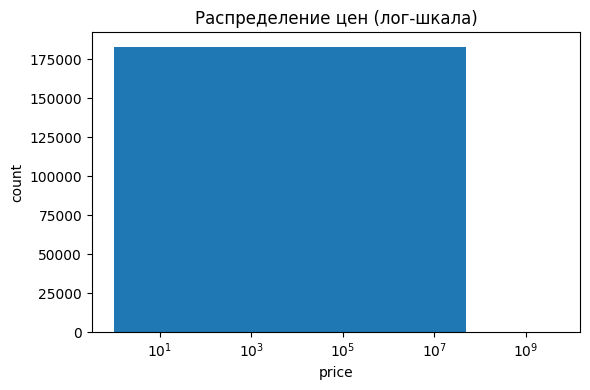

In [21]:
plot_df = sample_for_plots(train)

# Гистограмма цен (лог-шкала)
if "price" in plot_df.columns:
    price_vals = plot_df.select(pl.col("price").cast(pl.Float64)).to_series().to_numpy()
    price_vals = price_vals[np.isfinite(price_vals) & (price_vals > 0)]
    if len(price_vals) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(price_vals, bins=100)
        plt.xscale("log")
        plt.title("Распределение цен (лог-шкала)")
        plt.xlabel("price")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

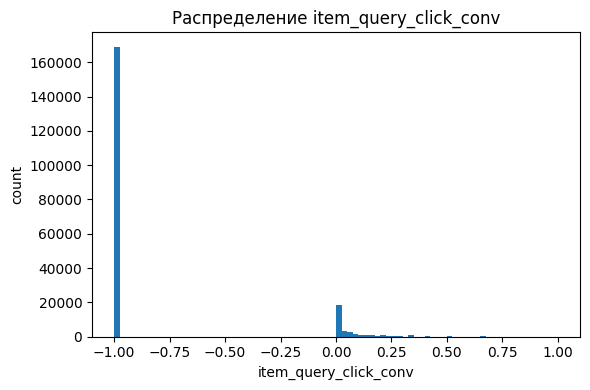

In [22]:
# Гистограмма item_query_click_conv
if "item_query_click_conv" in plot_df.columns:
    conv_vals = plot_df.select(pl.col("item_query_click_conv").cast(pl.Float64)).to_series().to_numpy()
    conv_vals = conv_vals[np.isfinite(conv_vals)]
    if len(conv_vals) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(conv_vals, bins=80)
        plt.title("Распределение item_query_click_conv")
        plt.xlabel("item_query_click_conv")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()


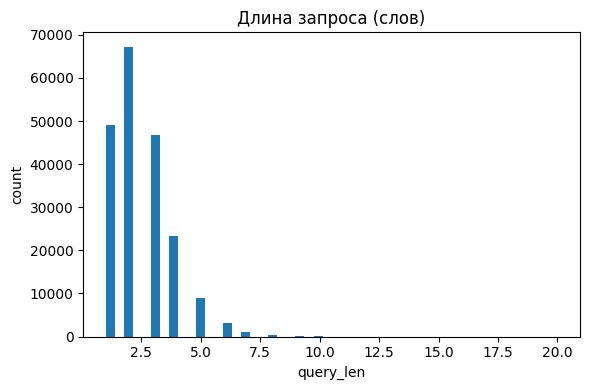

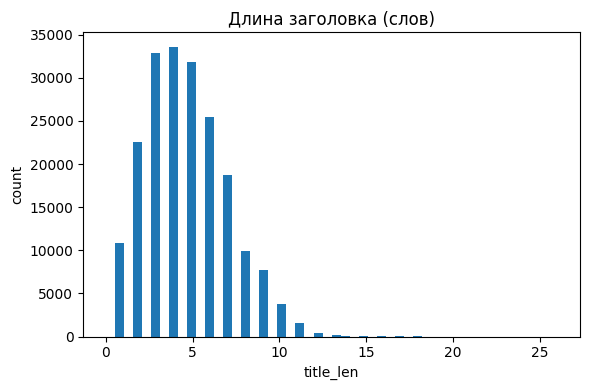

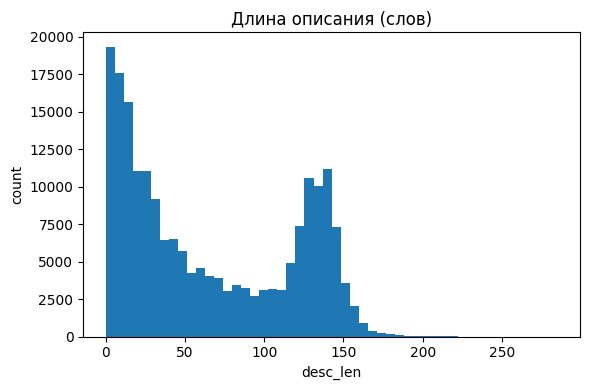

In [23]:
# Длины текстов
if has_text:
    q_len = plot_df.select(pl.col("query_len").cast(pl.Float64)).to_series().to_numpy()
    t_len = plot_df.select(pl.col("title_len").cast(pl.Float64)).to_series().to_numpy()
    d_len = plot_df.select(pl.col("desc_len").cast(pl.Float64)).to_series().to_numpy()

    plt.figure(figsize=(6, 4))
    plt.hist(q_len[np.isfinite(q_len)], bins=50)
    plt.title("Длина запроса (слов)")
    plt.xlabel("query_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(t_len[np.isfinite(t_len)], bins=50)
    plt.title("Длина заголовка (слов)")
    plt.xlabel("title_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(d_len[np.isfinite(d_len)], bins=50)
    plt.title("Длина описания (слов)")
    plt.xlabel("desc_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

In [24]:
test.head(5)

query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv
i64,i64,str,str,str,f32,f64,f32,i32,i32,i32,f32,f32
55,7540855789,"""1 сентября""","""Воздушные и гелиевые шары на 1…","""ВОЗДУШНЫЕ ШАРЫ К 1 СЕНТЯБРЯ 🍂 …",114.0,63.0,637640.0,114,2301564,637640,120.0,-1.0
55,7506720336,"""1 сентября""","""1 сентября фотозона""","""🎈Фотозона из шаров на 1 сентяб…",114.0,63.0,637640.0,114,2301564,637640,5000.0,-1.0
55,3110733862,"""1 сентября""","""Букет на 1 сентября из зефира""","""Букеты на 1 сентября Фото 1.…",114.0,63.0,637640.0,114,1090077,637640,1200.0,-1.0
55,7587733901,"""1 сентября""","""Спектакль-пантомима на 1 сентя…","""Спектакль-пантомима на 1 сентя…",114.0,63.0,637640.0,114,2301563,637640,0.0,-1.0
55,7552455685,"""1 сентября""","""Воздушные гелиевые шары с дост…","""Воздушные шары для оформления …",114.0,63.0,637640.0,114,2301564,637640,100.0,-1.0


In [25]:
ex = train.filter(pl.col("query_id") == 757116)
ex

query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact,query_tokens,title_tokens,desc_tokens,query_len,title_len,desc_len,overlap_q_title,overlap_q_desc
i64,i64,str,str,str,f32,f64,f32,i32,i32,i32,f32,f32,f32,list[str],list[str],list[str],u32,u32,u32,u32,u32
757116,7272304632,"""повар""","""Повар""","""""",112.0,62.0,0.0,112,62,638790,5000.0,0.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
757116,1911918753,"""повар""","""Повар""","""знание , европейской,итальянск…",112.0,62.0,0.0,112,62,637640,7000.0,0.027,0.0,"[""повар""]","[""повар""]","[""знание"", ""европейской"", … ""с""]",1,1,115,1,0
757116,4408324839,"""повар""","""Повар г/ц""","""Стаж более 25 лет из них 18в М…",112.0,62.0,0.0,112,62,637640,0.0,-1.0,0.0,"[""повар""]","[""повар"", ""г"", ""ц""]","[""стаж"", ""более"", … ""объёмах""]",1,3,20,1,0
757116,4600842279,"""повар""","""Повар""","""""",112.0,62.0,0.0,112,62,638790,80000.0,0.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
757116,3196572628,"""повар""","""Повар мне интересно""","""""",112.0,62.0,107620.0,112,62,637640,0.0,-1.0,0.0,"[""повар""]","[""повар"", ""мне"", ""интересно""]",[],1,3,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
757116,7253759823,"""повар""","""Повар с обучением""","""Поваром работала""",112.0,62.0,0.0,112,62,637770,0.0,0.053,0.0,"[""повар""]","[""повар"", ""с"", ""обучением""]","[""поваром"", ""работала""]",1,3,2,1,0
757116,7309049240,"""повар""","""Повар""","""""",112.0,62.0,0.0,112,62,637770,0.0,0.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0
757116,7661062654,"""повар""","""Повар""","""""",112.0,62.0,107620.0,112,62,637640,0.0,-1.0,0.0,"[""повар""]","[""повар""]",[],1,1,0,1,0


In [34]:
from typing import List, Dict, Any, Tuple
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Убедимся, что нужные колонки есть
req_cols = ["query_cat","query_mcat","query_loc","item_cat_id","item_mcat_id","item_loc","item_contact","price","item_query_click_conv"]
print("[check] present:", {c: (c in train.columns) for c in req_cols})

# Утилиты
def topk_counts(df: pl.DataFrame, col: str, k: int = 20) -> pl.DataFrame:
    return (df.group_by(col)
              .agg(pl.len().alias("cnt"))
              .sort("cnt", descending=True)
              .head(k))

def frac(x, by):  # среднее по условию (0/1 или числовое)
    return x.mean().over(by)

[check] present: {'query_cat': True, 'query_mcat': True, 'query_loc': True, 'item_cat_id': True, 'item_mcat_id': True, 'item_loc': True, 'item_contact': True, 'price': True, 'item_query_click_conv': True}


In [28]:
# Флаги матчей (cat/mcat/loc)
train_cat = (train
    .with_columns([
        (pl.col("query_cat")  == pl.col("item_cat_id")).cast(pl.Int8).alias("cat_match"),
        (pl.col("query_mcat") == pl.col("item_mcat_id")).cast(pl.Int8).alias("mcat_match"),
        (pl.col("query_loc")  == pl.col("item_loc")).cast(pl.Int8).alias("loc_match"),
        pl.col("query_mcat").is_null().cast(pl.Int8).alias("is_query_mcat_missing"),
        pl.col("item_contact").cast(pl.Int8).alias("tgt")
    ])
)

In [29]:
print("[head] with match flags:")
train_cat.head(5)

[head] with match flags:


query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact,query_tokens,title_tokens,desc_tokens,query_len,title_len,desc_len,overlap_q_title,overlap_q_desc,cat_match,mcat_match,loc_match,is_query_mcat_missing,tgt
i64,i64,str,str,str,f32,f64,f32,i32,i32,i32,f32,f32,f32,list[str],list[str],list[str],u32,u32,u32,u32,u32,i8,i8,i8,i8,i8
4,7349717282,"""ботинки детские zara 21""","""Ботинки детские Zara""","""Новые полуботинки фирмы Zara. …",29.0,38.0,624480.0,29,2179540,638660,500.0,-1.0,0.0,"[""ботинки"", ""детские"", … ""21""]","[""ботинки"", ""детские"", ""zara""]","[""новые"", ""полуботинки"", … ""15""]",4,3,25,3,2,1,0,0,0,0
4,7519735286,"""ботинки детские zara 21""","""Детские ботинки Zara унисекс""","""Крутые ботинки, в отличном сос…",29.0,38.0,624480.0,29,2179540,637640,250.0,-1.0,0.0,"[""ботинки"", ""детские"", … ""21""]","[""детские"", ""ботинки"", … ""унисекс""]","[""крутые"", ""ботинки"", … ""состоянии""]",4,4,5,3,1,1,0,0,0,0
4,4384449104,"""ботинки детские zara 21""","""Ботинки детские zara""","""Челси димесезонные Zara В иде…",29.0,38.0,624480.0,29,2179540,623880,1500.0,-1.0,0.0,"[""ботинки"", ""детские"", … ""21""]","[""ботинки"", ""детские"", ""zara""]","[""челси"", ""димесезонные"", … ""успели""]",4,3,9,3,1,1,0,0,0,0
4,7283365509,"""ботинки детские zara 21""","""Детские ботиночки Zara 21 разм…","""АВИТО ДОСТАВКА .21 РАЗМЕР.""",29.0,38.0,624480.0,29,2179540,628530,220.0,-1.0,0.0,"[""ботинки"", ""детские"", … ""21""]","[""детские"", ""ботиночки"", … ""размер""]","[""авито"", ""доставка"", … ""размер""]",4,5,4,3,1,1,0,0,0,0
4,4452768560,"""ботинки детские zara 21""","""Детские ботиночки zara размер …","""Детские ботинки Zara Размер 2…",29.0,38.0,624480.0,29,2179540,637640,1648.0,-1.0,1.0,"[""ботинки"", ""детские"", … ""21""]","[""детские"", ""ботиночки"", … ""21""]","[""детские"", ""ботинки"", … ""нет""]",4,5,20,3,4,1,0,0,0,1


In [30]:
# ## 1) Топ категорий и микрокатегорий (query vs item)

print("[top] query_cat:")
print(topk_counts(train_cat, "query_cat", 20))

print("\n[top] item_cat_id:")
print(topk_counts(train_cat, "item_cat_id", 20))

print("\n[top] query_mcat:")
print(topk_counts(train_cat, "query_mcat", 20))

print("\n[top] item_mcat_id:")
print(topk_counts(train_cat, "item_mcat_id", 20))


[top] query_cat:
shape: (20, 2)
┌───────────┬─────────┐
│ query_cat ┆ cnt     │
│ ---       ┆ ---     │
│ f32       ┆ u32     │
╞═══════════╪═════════╡
│ 0.0       ┆ 1747975 │
│ 114.0     ┆ 693215  │
│ 27.0      ┆ 679839  │
│ 112.0     ┆ 652631  │
│ 10.0      ┆ 546969  │
│ …         ┆ …       │
│ 106.0     ┆ 87448   │
│ 30.0      ┆ 83375   │
│ 39.0      ┆ 81905   │
│ 25.0      ┆ 80768   │
│ 88.0      ┆ 76581   │
└───────────┴─────────┘

[top] item_cat_id:
shape: (20, 2)
┌─────────────┬─────────┐
│ item_cat_id ┆ cnt     │
│ ---         ┆ ---     │
│ i32         ┆ u32     │
╞═════════════╪═════════╡
│ 114         ┆ 1000845 │
│ 27          ┆ 944585  │
│ 10          ┆ 732604  │
│ 112         ┆ 635044  │
│ 111         ┆ 550388  │
│ …           ┆ …       │
│ 101         ┆ 122936  │
│ 106         ┆ 120076  │
│ 32          ┆ 112561  │
│ 25          ┆ 106387  │
│ 28          ┆ 99284   │
└─────────────┴─────────┘

[top] query_mcat:
shape: (20, 2)
┌────────────┬─────────┐
│ query_mcat ┆ cnt     │

In [30]:
# ## 2) Матчи по категориям/микрокатегориям/локациям в разрезе query_cat

# агрегаты по query_cat
qc_agg = (train_cat
          .group_by("query_cat")
          .agg([
    pl.len().alias("rows"),
    pl.col("tgt").mean().alias("pos_rate"),
    pl.col("cat_match").mean().alias("cat_match_rate"),
    pl.col("mcat_match").mean().alias("mcat_match_rate"),
    pl.col("loc_match").mean().alias("loc_match_rate"),
    pl.col("is_query_mcat_missing").mean().alias("q_mcat_missing_rate"),
])
          .sort("rows", descending=True)
          )

print("[agg] per query_cat:")
qc_agg.head(20)


In [32]:
GROUP_COL = "item_cat_id"

text_df = (train
           .select(["item_id", "item_title", "item_description", GROUP_COL])
           .with_columns([
    pl.col("item_title").cast(pl.Utf8).fill_null(""),
    pl.col("item_description").cast(pl.Utf8).fill_null("")
])
           .filter(pl.col(GROUP_COL).is_not_null())
           )
print(text_df.shape, text_df.select(pl.col(GROUP_COL).n_unique()).item())


(7781790, 4) 53


In [37]:
N_TITLES = 60
N_DESCS  = 6

def sample_examples(df: pl.DataFrame, group_col: str, n_titles: int, n_descs: int):
    out = {}
    g = df.group_by(group_col)
    for gid, sub in g:
        # распаковка ключа группы
        if isinstance(gid, tuple):
            gid_val = gid[0]
        else:
            gid_val = gid

        sub = sub.sample(min(len(sub), n_titles*2), shuffle=True, seed=42)
        titles = sub.get_column("item_title").to_list()[:n_titles]
        descs = [d for d in sub.get_column("item_description").to_list() if d and len(d.split()) >= 8][:n_descs]
        out[int(gid_val)] = {"titles": titles, "descs": descs}
    return out


examples = sample_examples(text_df, GROUP_COL, N_TITLES, N_DESCS)
print(f"[examples] categories: {len(examples)}; sample gid -> counts:",
      [(k, len(v['titles']), len(v['descs'])) for k,v in list(examples.items())[:3]])

[examples] categories: 53; sample gid -> counts: [(0, 60, 6), (9, 60, 6), (426, 9, 6)]


In [38]:
# # Просмотр примеров по категориям (item_cat_id / item_mcat_id)

import polars as pl
import numpy as np
import re, os, textwrap


# Быстрые хелперы
def topk_counts(df: pl.DataFrame, col: str, k: int = 20) -> pl.DataFrame:
    return (df.group_by(col).agg(pl.len().alias("rows"))
            .sort("rows", descending=True).head(k))


def normalize_title(s: str) -> str:
    # для лёгкой дедупликации: lower + убрать лишнее
    s = s.lower().replace("ё", "е")
    s = re.sub(r"[^0-9a-zа-я\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def show_examples_for_cat(df: pl.DataFrame, group_col: str, gid: int, n: int = 20, with_desc: bool = False):
    sub = (df.filter(pl.col(group_col) == gid)
    .select(["item_id", "item_title", "item_description"])
    .with_columns([
        pl.col("item_title").fill_null("").cast(pl.Utf8),
        pl.col("item_description").fill_null("").cast(pl.Utf8),
    ]))
    if sub.is_empty():
        print(f"[{group_col}={gid}] нет данных")
        return

    # дедуп по нормализованному заголовку
    sub = (sub.with_columns(
        pl.col("item_title").map_elements(normalize_title, return_dtype=pl.Utf8).alias("_norm_title"))
           .unique(subset=["_norm_title"])
           .drop("_norm_title"))

    # случайные n
    sub = sub.sample(n=min(n, sub.height), shuffle=True, seed=42)

    print(f"\n=== {group_col}={gid} | примеры: {sub.height} ===")
    for row in sub.iter_rows(named=True):
        ttl = row["item_title"]
        print("•", ttl)
        if with_desc and row["item_description"]:
            # короткая подрезка описания
            d = textwrap.shorten(row["item_description"], width=140, placeholder="…")
            print("   ", d)


In [39]:
# ## 1) Топ-20 item_cat_id и item_mcat_id

print("[top] item_cat_id:")
print(topk_counts(train, "item_cat_id", 20))

print("\n[top] item_mcat_id:")
print(topk_counts(train, "item_mcat_id", 20))


[top] item_cat_id:
shape: (20, 2)
┌─────────────┬─────────┐
│ item_cat_id ┆ rows    │
│ ---         ┆ ---     │
│ i32         ┆ u32     │
╞═════════════╪═════════╡
│ 114         ┆ 1000845 │
│ 27          ┆ 944585  │
│ 10          ┆ 732604  │
│ 112         ┆ 635044  │
│ 111         ┆ 550388  │
│ …           ┆ …       │
│ 101         ┆ 122936  │
│ 106         ┆ 120076  │
│ 32          ┆ 112561  │
│ 25          ┆ 106387  │
│ 28          ┆ 99284   │
└─────────────┴─────────┘

[top] item_mcat_id:
shape: (20, 2)
┌──────────────┬────────┐
│ item_mcat_id ┆ rows   │
│ ---          ┆ ---    │
│ i32          ┆ u32    │
╞══════════════╪════════╡
│ 62           ┆ 635044 │
│ 5533         ┆ 118754 │
│ 799          ┆ 92685  │
│ 2278163      ┆ 89042  │
│ 2278181      ┆ 85626  │
│ …            ┆ …      │
│ 29           ┆ 51575  │
│ 25           ┆ 46581  │
│ 86470        ┆ 46229  │
│ 1289835      ┆ 42380  │
│ 5541         ┆ 42353  │
└──────────────┴────────┘


In [40]:
show_examples_for_cat(train, "item_cat_id", gid=114, n=15, with_desc=False)
show_examples_for_cat(train, "item_cat_id", gid=62,  n=15, with_desc=True)


=== item_cat_id=114 | примеры: 15 ===
• Химчистка мебели чистка дивана матраса
• Автоподбор. Автоэксперт. Подбор авто
• Маникюр I Педикюр
• Скупка Холодильники Стиралки
• Модель для фото и видео съёмки
• Мытье мойка окон, балконов, лоджий, витрин
• Сдам в аренду гараж
• Сауна «Сказка»
• Костоправ массаж убираю любую боль
• Услуги мини экскаватора с буром
• Вышивка, брендирование текстиля
• Полусухая стяжка пола в квартире
• Лазерная эпиляция в Уфе/с. Нагаево
• Бурение скважин,Прокачка,Промывка
• Услуги мелкого ремонта

=== item_mcat_id=62 | примеры: 15 ===
• Продавец на одежду или ювелирнный
    Ищу работу продавца,можно в бутик,работала с разными группами товаров,так же,рассмотрю работу островного типа,магазинчик от прямого…
• Администратор, старший продавец, менеджер
    Характерны такие качества, как - ответственность , коммуникабельность, быстрая обучаемость, позитивная жизненная позиция,…
• Водитель,водитель-курьер,курьер,помощник
    обучаемость, внимательность, трудолюбие, пунк

In [41]:
# ## 3) Пройтись по топ-N категориям и вывести по M примеров на каждую

TOP_N = 10
EXAMPLES_PER_CAT = 10

top_item_cat = topk_counts(train, "item_cat_id", TOP_N)["item_cat_id"].to_list()
for gid in top_item_cat:
    show_examples_for_cat(train, "item_cat_id", int(gid), n=EXAMPLES_PER_CAT, with_desc=False)

top_item_mcat = topk_counts(train, "item_mcat_id", TOP_N)["item_mcat_id"].to_list()
for gid in top_item_mcat:
    show_examples_for_cat(train, "item_mcat_id", int(gid), n=EXAMPLES_PER_CAT, with_desc=True)




=== item_cat_id=114 | примеры: 10 ===
• Скупка электроники Компьютеров Техники
• Замена, врезка, ремонт замков
• Реклама, печать, банер, бумага, наклейки
• Изготовление выхлопных систем
• Аренда зала, Студия - танца с пилонами
• Татуировки для ценителей качества
• Аренда авто в Абхазии без залога. Кпп Псоу.Гагра
• Сауна, хаммам с тёплым бассейном
• Маникюр Нижний Тагил Выя
• Маникюр, педикюр,наращивание, радиогорка северная

=== item_cat_id=27 | примеры: 10 ===
• Шарф barbour tartan
• Dickies Edwardsport Cargo W28 L30 штаны мужские
• 11US adidas RAF simons ozweego оригинал
• Кроссовки Nike Air Force 1 Black Оригинал
• Ботинки новые кожаные bronx 40 р
• Фата для девичника розовая
• Шерстяной кардиган Massimo Dutti, размер M
• Дредокудри
• Юбка серая, M
• Новые р 38 Barracuda замшевые шлепанцы

=== item_cat_id=10 | примеры: 10 ===
• Передний бампер м5 бмв Е39 бесплатная доставка
• Michelin Pilot Sport 4 SUV 315/30 R23 и 275/35 R23
• Мотоэкиперовка Эндуро защита
• Печка в сборе kaptur кл

In [42]:
# # Сколько всего категорий есть (item vs query), train и test

def nunique(df: pl.DataFrame, col: str) -> int:
    return int(df.select(pl.col(col).n_unique()).item())


def nulls(df: pl.DataFrame, col: str) -> int:
    return int(df.select(pl.col(col).is_null().sum()).item())


cols_query = ["query_cat", "query_mcat", "query_loc"]
cols_item = ["item_cat_id", "item_mcat_id", "item_loc"]

print("=== TRAIN: уникальные значения ===")
for col in cols_query + cols_item:
    n = nunique(train, col)
    n_null = nulls(train, col) if col.startswith("query_") else 0
    print(f"{col:16s} → unique={n:8d}" + (f", nulls={n_null}" if n_null else ""))

print("\n=== TEST: уникальные значения ===")
for col in cols_query + cols_item:
    n = nunique(test, col)
    n_null = nulls(test, col) if col.startswith("query_") else 0
    print(f"{col:16s} → unique={n:8d}" + (f", nulls={n_null}" if n_null else ""))

# сколько значений в TEST, которых не было в TRAIN (полезно для фичей)
print("\n=== TEST unseen vs TRAIN (сколько новых значений) ===")
for col in cols_query + cols_item:
    tr_vals = set(train.select(pl.col(col)).to_series().drop_nulls().to_list())
    te_vals = set(test.select(pl.col(col)).to_series().drop_nulls().to_list())
    unseen = len(te_vals - tr_vals)
    print(f"{col:16s} → unseen_in_test={unseen}")


=== TRAIN: уникальные значения ===
query_cat        → unique=      64
query_mcat       → unique=    2062, nulls=1761233
query_loc        → unique=    2629
item_cat_id      → unique=      53
item_mcat_id     → unique=    5312
item_loc         → unique=    3912

=== TEST: уникальные значения ===
query_cat        → unique=      62
query_mcat       → unique=     793, nulls=76025
query_loc        → unique=     825
item_cat_id      → unique=      52
item_mcat_id     → unique=    2757
item_loc         → unique=    2772

=== TEST unseen vs TRAIN (сколько новых значений) ===
query_cat        → unseen_in_test=0
query_mcat       → unseen_in_test=4
query_loc        → unseen_in_test=19
item_cat_id      → unseen_in_test=0
item_mcat_id     → unseen_in_test=11
item_loc         → unseen_in_test=5


In [43]:
# # Экспорт примеров по категориям: query ↔ item пары (запрос, заголовок, описание)
# Пишем CSV-файлы по каждой категории + общий index

import os, re, textwrap
import polars as pl
import numpy as np

np.random.seed(42)

# ---- параметры экспорта ----
OUT_DIR = "cat_samples"
PER_CAT = 120  # сколько пар сохранить на категорию
MAX_PER_QUERY = 5  # ограничение, сколько примеров брать с одного query_id (для разнообразия)
DEDUP_TITLES = True  # дедуп по нормализованному заголовку
INCLUDE_TEST = False  # при желании выгружать и из test (без таргета)

os.makedirs(OUT_DIR, exist_ok=True)


# ---- вспомогательное ----
def norm_txt(s: str) -> str:
    s = (s or "").lower().replace("ё", "е")
    s = re.sub(r"[^0-9a-zа-я\s]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()


def dedup_by_norm_title(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    return (df.with_columns(pl.col("item_title").map_elements(norm_txt, return_dtype=pl.Utf8).alias("_nt"))
            .unique(subset=["_nt"])
            .drop("_nt"))


def sample_pairs_for_group(df: pl.DataFrame, group_col: str, gid, per_cat=PER_CAT,
                           max_per_query=MAX_PER_QUERY) -> pl.DataFrame:
    sub = df.filter(pl.col(group_col) == gid)
    if sub.is_empty():
        return sub

    # (опц.) дедуп по заголовку
    if DEDUP_TITLES:
        sub = dedup_by_norm_title(sub)

    # лёгкая диверсификация по запросам: берём не больше max_per_query на query_id
    # сортировка для детерминизма
    sub = sub.sort(["query_id", "item_id"])
    sub = (sub.with_columns(pl.int_range(0, pl.len()).alias("_row"))
           .with_columns(pl.col("_row").rank("dense").over("query_id").alias("_rank_in_q"))
           .filter(pl.col("_rank_in_q") <= max_per_query)
           .drop(["_row", "_rank_in_q"]))

    # финальный случайный сэмпл
    n = min(per_cat, sub.height)
    if n < sub.height:
        sub = sub.sample(n=n, shuffle=True, seed=42)

    return sub


def write_category_csv(df: pl.DataFrame, path: str):
    cols = [
        "query_id", "item_id",
        "query_text", "item_title", "item_description",
        "query_cat", "query_mcat", "query_loc",
        "item_cat_id", "item_mcat_id", "item_loc",
        "price", "item_query_click_conv"
    ]
    # таргет добавим, если он есть
    if "item_contact" in df.columns:
        cols.append("item_contact")
    # убедимся, что колонки существуют
    cols_present = [c for c in cols if c in df.columns]
    df.select(cols_present).write_csv(path)


def summarize_for_group(df: pl.DataFrame, group_col: str, gid) -> dict:
    sub = df.filter(pl.col(group_col) == gid)
    if sub.is_empty():
        return {"group_col": group_col, "group_id": gid, "rows": 0}
    rows = sub.height
    n_queries = int(sub.select(pl.col("query_id").n_unique()).item())
    pos_rate = float(
        sub.select(pl.col("item_contact").cast(pl.Float64).mean()).item()) if "item_contact" in sub.columns else float(
        "nan")
    price_med = float(
        sub.select(pl.col("price").cast(pl.Float64).median()).item()) if "price" in sub.columns else float("nan")
    return {
        "group_col": group_col, "group_id": gid, "rows": rows,
        "n_queries": n_queries, "pos_rate": pos_rate, "price_median": price_med
    }


def ensure_group_col(df: pl.DataFrame, col: str) -> pl.DataFrame:
    # для query_mcat, где встречаются null — заменим на -1 для удобства группировки/имён файлов
    if col == "query_mcat":
        return df.with_columns(pl.when(pl.col(col).is_null()).then(pl.lit(-1)).otherwise(pl.col(col)).alias(col))
    return df


# общий список группировок
GROUPS = ["item_cat_id", "item_mcat_id", "query_cat", "query_mcat"]


In [44]:
# ## Соберём базовую «пары»-таблицу из train (и опц. test)

# Берём поля, которые хотим видеть в выгрузке
BASE_COLS = [
    "query_id", "item_id",
    "query_text", "item_title", "item_description",
    "query_cat", "query_mcat", "query_loc",
    "item_cat_id", "item_mcat_id", "item_loc",
    "price", "item_query_click_conv", "item_contact"
]
pairs_train = train.select([c for c in BASE_COLS if c in train.columns]).clone()
pairs_test = test.select([c for c in BASE_COLS if c in test.columns]).clone() if INCLUDE_TEST else None

# нормализуем null у query_mcat
pairs_train = ensure_group_col(pairs_train, "query_mcat")
if pairs_test is not None:
    pairs_test = ensure_group_col(pairs_test, "query_mcat")


In [45]:
# ## Экспорт по каждой группе: создаём поддиректории, пишем CSV и индекс

index_rows = []

for group_col in GROUPS:
    # подготовка директорий
    subdir = os.path.join(OUT_DIR, group_col)
    os.makedirs(subdir, exist_ok=True)

    # уникальные значения групп
    gids = pairs_train.select(pl.col(group_col).unique()).to_series().to_list()

    # сводка по train
    for gid in gids:
        # выборка пар
        sample_df = sample_pairs_for_group(pairs_train, group_col, gid, per_cat=PER_CAT, max_per_query=MAX_PER_QUERY)
        if sample_df.is_empty():
            continue
        # путь сохранения
        fname = f"samples_{group_col}_{gid}.csv"
        fpath = os.path.join(subdir, fname)
        write_category_csv(sample_df, fpath)

        # сводка
        summ = summarize_for_group(pairs_train, group_col, gid)
        summ.update({"file": os.path.relpath(fpath, OUT_DIR)})
        index_rows.append(summ)

    # (опц.) выгрузка из test
    if pairs_test is not None:
        gids_test = pairs_test.select(pl.col(group_col).unique()).to_series().to_list()
        for gid in gids_test:
            sample_df = sample_pairs_for_group(pairs_test, group_col, gid, per_cat=min(60, PER_CAT),
                                               max_per_query=MAX_PER_QUERY)
            if sample_df.is_empty():
                continue
            fname = f"samples_TEST_{group_col}_{gid}.csv"
            fpath = os.path.join(subdir, fname)
            write_category_csv(sample_df, fpath)
            # индекс для test можно не писать (без таргета), но добавим пометку
            index_rows.append({"group_col": group_col, "group_id": gid, "rows": sample_df.height,
                               "n_queries": int(sample_df.select(pl.col("query_id").n_unique()).item()),
                               "pos_rate": float("nan"), "price_median": float(sample_df.select(
                    pl.col("price").cast(pl.Float64).median()).item()) if "price" in sample_df.columns else float(
                    "nan"),
                               "file": os.path.relpath(fpath, OUT_DIR)})

# собираем и сохраняем индекс
index_df = pl.DataFrame(index_rows) if index_rows else pl.DataFrame(schema={
    "group_col": pl.Utf8, "group_id": pl.Int64, "rows": pl.Int64, "n_queries": pl.Int64,
    "pos_rate": pl.Float64, "price_median": pl.Float64, "file": pl.Utf8
})
INDEX_PATH = os.path.join(OUT_DIR, "index.csv")
index_df.write_csv(INDEX_PATH)
print(f"[done] saved index → {INDEX_PATH}, rows={index_df.height}")


[done] saved index → cat_samples\index.csv, rows=7491
